In [1]:
# MODIFY! 
# use RobustScaler! 
model_name = 'RandFoNFE'

# Import Libraries & Data 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('./data/dl-nfe-ns.csv')
X = df.drop('throughput',axis=1)
y = df['throughput']

---

# Scale Data

In [4]:
# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Scale the data
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(X_train)

RobustScaler()

In [5]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Determine Hyperparameters

## Determine Max Features

In [6]:
# MODIFY!
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(warm_start=True)
model

RandomForestRegressor(warm_start=True)

In [7]:
p_grid = {
    'max_features':['auto', 'sqrt', 'log2']
}

In [8]:
from sklearn.model_selection import GridSearchCV

In [9]:
grid_model = GridSearchCV(
    estimator=model,
    param_grid =p_grid, 
    scoring='neg_mean_squared_error',
    cv=10, 
    verbose=1
)

In [10]:
grid_model.fit(X_train,y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   28.0s finished


GridSearchCV(cv=10, estimator=RandomForestRegressor(warm_start=True),
             param_grid={'max_features': ['auto', 'sqrt', 'log2']},
             scoring='neg_mean_squared_error', verbose=1)

In [11]:
grid_model.best_params_

{'max_features': 'auto'}

In [12]:
hp = pd.Series(name=f'{model_name} HP', data=grid_model.best_params_)

In [13]:
hp

max_features    auto
Name: RandFoNFE HP, dtype: object

In [14]:
hp.to_csv(f'./hyperparameters/{model_name}-hp.csv')

## Determine Number of Estimators

In [17]:
# MODIFY!
import time

estimators = [5,10,25,50,100,500,1000,2000]
scores_list = []

from sklearn.ensemble import RandomForestRegressor

for e in estimators: 
    start = time.time()
    print(f'Starting {e} estimators')
    score_model = RandomForestRegressor(
        n_estimators=e,
        max_features=grid_model.best_params_['max_features']
    )
    
    from sklearn.model_selection import cross_validate

    scores = cross_validate(
        score_model, 
        X_train, 
        y_train,
        scoring=[
            'neg_mean_absolute_error',
            'neg_mean_squared_error',
            'neg_root_mean_squared_error'
        ],
        cv=10
    )
    
    scores = pd.DataFrame(scores)
    scores
    mean_scores = scores.mean()
    scores_list.append(mean_scores)
    print(f'Done with {e} estimators')
    end = time.time()
    print(f'Elapsed time: {end - start}')
    print('\n')

Starting 5 estimators
Done with 5 estimators
Elapsed time: 1.2854740619659424


Starting 10 estimators
Done with 10 estimators
Elapsed time: 2.3488268852233887


Starting 25 estimators
Done with 25 estimators
Elapsed time: 5.565361022949219


Starting 50 estimators
Done with 50 estimators
Elapsed time: 13.010085105895996


Starting 100 estimators
Done with 100 estimators
Elapsed time: 25.729158878326416


Starting 500 estimators
Done with 500 estimators
Elapsed time: 130.33762121200562


Starting 1000 estimators
Done with 1000 estimators
Elapsed time: 236.18822598457336


Starting 2000 estimators
Done with 2000 estimators
Elapsed time: 598.978747844696




In [18]:
scores_df = pd.DataFrame(scores_list)

In [19]:
scores_df

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
0,0.123868,0.003671,-3.403930,-22.008160,-4.674958
1,0.228516,0.005463,-3.158966,-19.350467,-4.383474
2,0.549501,0.005670,-3.128277,-18.653839,-4.307584
3,1.285379,0.011500,-3.052466,-17.864684,-4.211412
4,2.547330,0.022418,-3.055044,-17.947391,-4.223487
5,12.915429,0.102786,-3.038092,-17.797980,-4.203056
6,23.394587,0.191180,-3.038006,-17.804321,-4.204119
7,59.087064,0.717331,-3.034503,-17.749638,-4.197672


In [20]:
scores_df['Est'] = estimators

In [21]:
scores_df

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,Est
0,0.123868,0.003671,-3.403930,-22.008160,-4.674958,5
1,0.228516,0.005463,-3.158966,-19.350467,-4.383474,10
2,0.549501,0.005670,-3.128277,-18.653839,-4.307584,25
3,1.285379,0.011500,-3.052466,-17.864684,-4.211412,50
4,2.547330,0.022418,-3.055044,-17.947391,-4.223487,100
5,12.915429,0.102786,-3.038092,-17.797980,-4.203056,500
6,23.394587,0.191180,-3.038006,-17.804321,-4.204119,1000
7,59.087064,0.717331,-3.034503,-17.749638,-4.197672,2000


# Export Scores for Number of Estimators

In [22]:
# mean_scores

In [23]:
scores_df = scores_df.rename(columns={
    'fit_time':'Fit Time',
    'score_time':'Score Time',
    'test_neg_mean_absolute_error':'MAE',
    'test_neg_mean_squared_error':'MSE',
    'test_neg_root_mean_squared_error':'RMSE'
})

In [24]:
scores_df

,Fit Time,Score Time,MAE,MSE,RMSE,Est
0,0.123868,0.003671,-3.403930,-22.008160,-4.674958,5
1,0.228516,0.005463,-3.158966,-19.350467,-4.383474,10
2,0.549501,0.005670,-3.128277,-18.653839,-4.307584,25
3,1.285379,0.011500,-3.052466,-17.864684,-4.211412,50
4,2.547330,0.022418,-3.055044,-17.947391,-4.223487,100
5,12.915429,0.102786,-3.038092,-17.797980,-4.203056,500
6,23.394587,0.191180,-3.038006,-17.804321,-4.204119,1000
7,59.087064,0.717331,-3.034503,-17.749638,-4.197672,2000


In [25]:
scores_df[['MAE','MSE','RMSE']] = scores_df[['MAE','MSE','RMSE']].apply(lambda x : abs(x))

In [26]:
scores_df
# we go for 25 estimations. Note that from 25 -> 50 estimations the error metrics worsen

,Fit Time,Score Time,MAE,MSE,RMSE,Est
0,0.123868,0.003671,3.403930,22.008160,4.674958,5
1,0.228516,0.005463,3.158966,19.350467,4.383474,10
2,0.549501,0.005670,3.128277,18.653839,4.307584,25
3,1.285379,0.011500,3.052466,17.864684,4.211412,50
4,2.547330,0.022418,3.055044,17.947391,4.223487,100
5,12.915429,0.102786,3.038092,17.797980,4.203056,500
6,23.394587,0.191180,3.038006,17.804321,4.204119,1000
7,59.087064,0.717331,3.034503,17.749638,4.197672,2000


In [27]:
scores_df.to_csv(f'./scores/{model_name}-score.csv')

In [28]:
pct_scores_df = scores_df.pct_change()

In [29]:
pct_scores_df

,Fit Time,Score Time,MAE,MSE,RMSE,Est
0,NaN,NaN,NaN,NaN,NaN,NaN
1,0.844829,0.488303,-0.071965,-0.120759,-0.062350,1.0
2,1.404649,0.037797,-0.009715,-0.036001,-0.017313,1.5
3,1.339178,1.028199,-0.024234,-0.042305,-0.022326,1.0
4,0.981773,0.949449,0.000845,0.004630,0.002867,1.0
5,4.070183,3.585024,-0.005549,-0.008325,-0.004837,4.0
6,0.811367,0.859986,-0.000028,0.000356,0.000253,1.0
7,1.525672,2.752125,-0.001153,-0.003071,-0.001534,1.0


In [30]:
pct_scores_df.style.background_gradient() 
# we choose index 4, 100 Estimations <- 
    # Score time decrease 3->4 & Score time increase dramatically 4->5
    # unsubstantial decrease MSE & RMSE 4->5 compared to 3->4

,Fit Time,Score Time,MAE,MSE,RMSE,Est
0,nan,nan,nan,nan,nan,nan
1,0.844829,0.488303,-0.071965,-0.120759,-0.062350,1.000000
2,1.404649,0.037797,-0.009715,-0.036001,-0.017313,1.500000
3,1.339178,1.028199,-0.024234,-0.042305,-0.022326,1.000000
4,0.981773,0.949449,0.000845,0.004630,0.002867,1.000000
5,4.070183,3.585024,-0.005549,-0.008325,-0.004837,4.000000
6,0.811367,0.859986,-0.000028,0.000356,0.000253,1.000000
7,1.525672,2.752125,-0.001153,-0.003071,-0.001534,1.000000


# Score Model

In [31]:
# MODIFY!
# adopt number of estimators from the previous section

score_model = RandomForestRegressor(n_estimators=100)
score_model

RandomForestRegressor()

In [32]:
from sklearn.model_selection import cross_validate

scores = cross_validate(
    score_model, 
    X_train, 
    y_train,
    scoring=[
        'neg_mean_absolute_error',
        'neg_mean_squared_error',
        'neg_root_mean_squared_error'
    ],
    cv=10
)

In [33]:
scores = pd.DataFrame(scores)

In [34]:
scores

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
0,4.035935,0.024283,-3.019149,-15.277321,-3.908621
1,7.338989,0.077195,-2.982036,-17.235342,-4.151547
2,5.684114,0.067306,-2.920479,-15.378280,-3.921515
3,7.690343,0.042963,-3.317819,-22.994946,-4.795305
4,7.334403,0.017639,-3.182762,-22.382037,-4.730966
5,3.733059,0.025458,-2.976977,-18.484458,-4.299356
6,2.564030,0.025956,-2.739721,-12.644897,-3.555966
7,2.380148,0.015738,-3.029372,-17.369075,-4.167622
8,2.376922,0.018468,-3.102948,-17.140046,-4.140054
9,2.560681,0.024030,-3.167243,-19.027413,-4.362042


In [35]:
mean_scores = scores.mean()

In [36]:
mean_scores

fit_time                             4.569862
score_time                           0.033904
test_neg_mean_absolute_error        -3.043851
test_neg_mean_squared_error        -17.793381
test_neg_root_mean_squared_error    -4.203299
dtype: float64

# Export Scores

In [37]:
mean_scores = mean_scores.rename(f'{model_name}')

In [38]:
mean_scores[[2,3,4]] = mean_scores[[2,3,4]].apply(abs)

In [39]:
# mean_scores

In [40]:
mean_scores = mean_scores.rename({
    'fit_time':'Fit Time',
    'score_time':'Score Time',
    'test_neg_mean_absolute_error':'MAE',
    'test_neg_mean_squared_error':'MSE',
    'test_neg_root_mean_squared_error':'RMSE'
})

In [41]:
mean_scores

Fit Time       4.569862
Score Time     0.033904
MAE            3.043851
MSE           17.793381
RMSE           4.203299
Name: RandFoNFE, dtype: float64

In [42]:
mean_scores['STD FT'] = scores.fit_time.std()
mean_scores['STD ST'] = scores.score_time.std()
mean_scores['STD MAE'] = scores.test_neg_mean_absolute_error.std()
mean_scores['STD MSE'] = scores.test_neg_mean_squared_error.std()
mean_scores['STD RMSE'] = scores.test_neg_root_mean_squared_error.std()

In [43]:
mean_scores

Fit Time       4.569862
Score Time     0.033904
MAE            3.043851
MSE           17.793381
RMSE           4.203299
STD FT         2.234553
STD ST         0.021678
STD MAE        0.159827
STD MSE        3.157019
STD RMSE       0.373654
Name: RandFoNFE, dtype: float64

In [44]:
mean_scores.to_csv(f'./scores/{model_name}-100-score.csv')

# Holdout Test

In [45]:
score_model.fit(X_train,y_train)

RandomForestRegressor()

In [46]:
y_holdout = score_model.predict(X_test)

<AxesSubplot:ylabel='Count'>

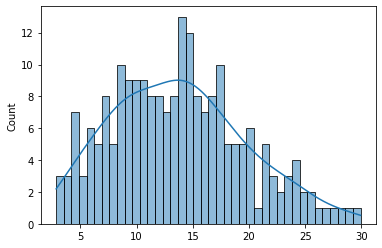

In [47]:
sns.histplot(y_holdout,bins=40,kde=True)

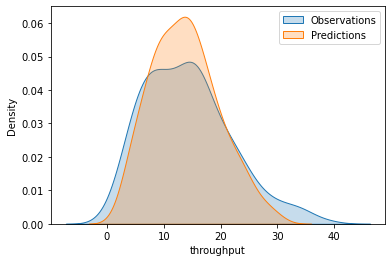

In [48]:
fig,ax = plt.subplots()

sns.kdeplot(y_test, ax=ax, shade=True, label='Observations')
sns.kdeplot(y_holdout, ax=ax,shade=True,label='Predictions')

ax.legend(loc='best')

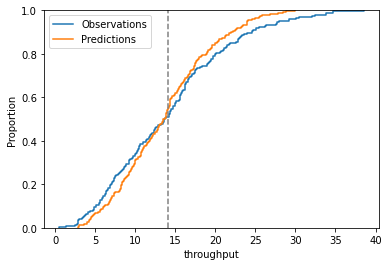

In [49]:
fig,ax = plt.subplots()

sns.ecdfplot(y_test, ax=ax, label='Observations')
sns.ecdfplot(y_holdout, ax=ax,label='Predictions')
plt.axvline(x=y_test.mean(),color='grey',linestyle='--')

ax.legend(loc='best')

In [50]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test,y_holdout)
mse = mean_squared_error(y_test,y_holdout)
rmse = np.sqrt(mse)

In [51]:
err_df = pd.DataFrame(data=[mae, mse, rmse],index=['MAE','MSE','RMSE'],columns=[f'{model_name}'])
err_df

,RandFoNFE
MAE,3.373077
MSE,21.179184
RMSE,4.602085


In [52]:
err_df.to_csv(f'./holdout-test/{model_name}-err.csv')
# mean_scores.to_csv(f'./opt-model-err/{model_name}-err.csv')

In [53]:
res = y_test - y_holdout
res.describe().drop('count')

mean     0.426972
std      4.592929
min    -11.184142
25%     -2.469454
50%     -0.184351
75%      2.690662
max     19.466110
Name: throughput, dtype: float64

<AxesSubplot:xlabel='throughput', ylabel='Count'>

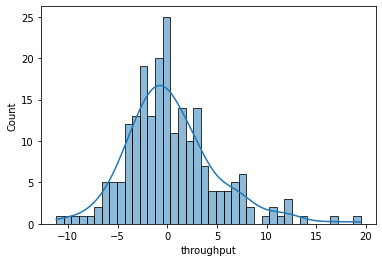

In [54]:
sns.histplot(data=res, kde=True,bins=40)

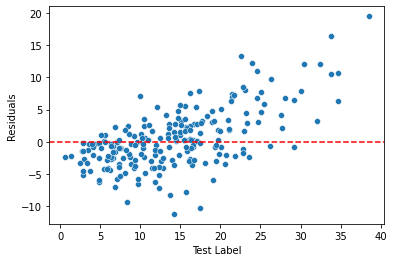

In [55]:
ax = sns.scatterplot(x=y_test, y=res)
ax.set(ylabel='Residuals', xlabel='Test Label')
plt.axhline(y=0,color='red',linestyle='--')

# there should be no clear pattern / curve in the plot
# we see a positive correlation between Test Label and Residuals -> later models should avoid this pattern

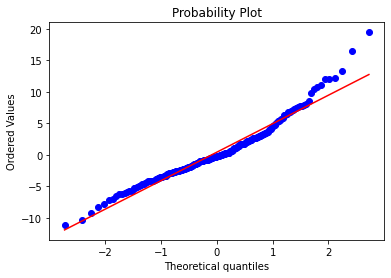

In [56]:
import scipy as sp

fig, ax = plt.subplots()
sp.stats.probplot(res,plot=ax);

# Export Optimized Model

In [57]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(X)

RobustScaler()

In [58]:
# MODIFY! 
X = scaler.transform(X)

op_model = score_model

op_model.fit(X,y)

RandomForestRegressor()

In [59]:
y_pred = op_model.predict(X)

<AxesSubplot:ylabel='Count'>

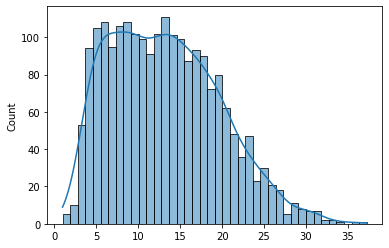

In [60]:
sns.histplot(y_pred,bins=40,kde=True)

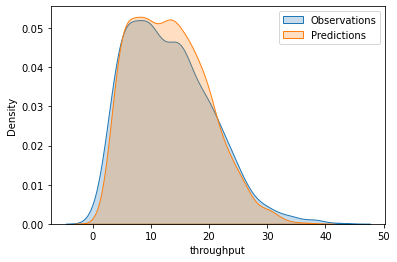

In [61]:
fig,ax = plt.subplots()

sns.kdeplot(y, ax=ax, shade=True, label='Observations')
sns.kdeplot(y_pred, ax=ax,shade=True,label='Predictions')

ax.legend(loc='best')

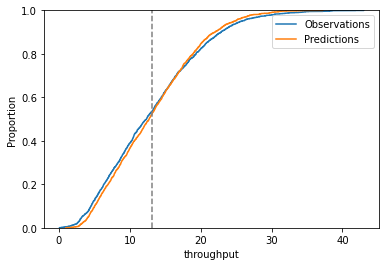

In [62]:
fig,ax = plt.subplots()

sns.ecdfplot(y, ax=ax, label='Observations')
sns.ecdfplot(y_pred, ax=ax,label='Predictions')
plt.axvline(x=y.mean(),color='grey',linestyle='--')

ax.legend(loc='best')

In [63]:
mae = mean_absolute_error(y,y_pred)
mse = mean_squared_error(y,y_pred)
rmse = np.sqrt(mse)

In [64]:
err_df = pd.DataFrame(data=[mae, mse, rmse],index=['MAE','MSE','RMSE'],columns=[f'{model_name}'])
err_df

,RandFoNFE
MAE,1.132859
MSE,2.519387
RMSE,1.587258


In [65]:
err_df.to_csv(f'./model-err/{model_name}-err.csv')
# mean_scores.to_csv(f'./opt-model-err/{model_name}-err.csv')

In [66]:
from joblib import dump, load
dump(op_model, f'./opt-models/{model_name}-model.joblib')

['./opt-models/RandFoNFE-model.joblib']

In [67]:
res = y - y_pred
res.describe().drop('count')

mean    -0.050033
std      1.586839
min     -9.592341
25%     -0.886737
50%     -0.145351
75%      0.685385
max     12.893856
Name: throughput, dtype: float64

<AxesSubplot:xlabel='throughput', ylabel='Count'>

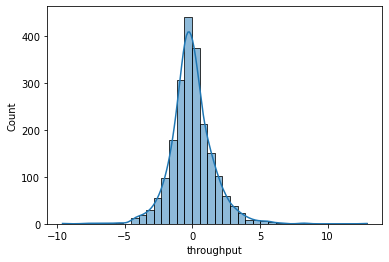

In [68]:
sns.histplot(data=res, kde=True,bins=40)

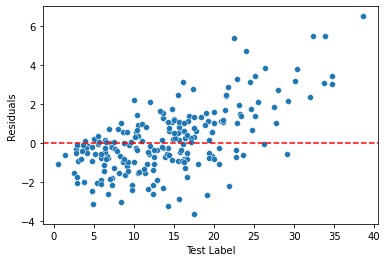

In [69]:
ax = sns.scatterplot(x=y_test, y=res)
ax.set(ylabel='Residuals', xlabel='Test Label')
plt.axhline(y=0,color='red',linestyle='--')

# there should be no clear pattern / curve in the plot
# we see a positive correlation between Test Label and Residuals -> later models should avoid this pattern

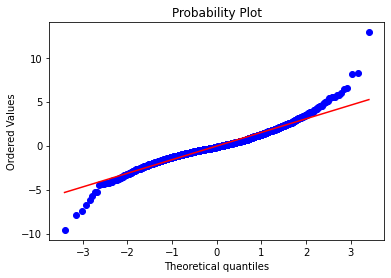

In [70]:
import scipy as sp

fig, ax = plt.subplots()
sp.stats.probplot(res,plot=ax);

DONE!